In [46]:
import numpy as np
import pandas as pd
import re
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

In [21]:
data = pd.read_csv('IMDBe2.csv')
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


In [22]:
data = data[data.sentiment != "Neutral"]
data['review'] = data['review'].apply(lambda x: x.lower()) #Converts to lower case
data['review'] = data['review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # Replaces any non alpha-numeric data with empty string

print(data[ data['sentiment'] == 'positive'].size)
print(data[ data['sentiment'] == 'negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ') 
    
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ') 
tokenizer.fit_on_texts(data['review'].values) # breaking down text to individual tokens
X = tokenizer.texts_to_sequences(data['review'].values) #converts each string to a sequence of integer tokens
X = pad_sequences(X) # ensures that all the sequences are of same length

2000
2000


In [12]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1700, 1324) (1700, 2)
(300, 1324) (300, 2)


In [16]:
model = Sequential()
model.add(Embedding(max_features,48,input_length = X.shape[1]))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(2,activation = 'softmax'))
model.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1324, 48)          96000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              57856     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 154,114
Trainable params: 154,114
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history = model.fit(X_train,Y_train,batch_size=32,epochs=10, verbose=1)

Epoch 1/10
54/54 [==============================] - 28s 466ms/step - loss: 0.6927 - accuracy: 0.5059
Epoch 2/10
54/54 [==============================] - 28s 523ms/step - loss: 0.6283 - accuracy: 0.6824
Epoch 3/10
54/54 [==============================] - 28s 517ms/step - loss: 0.4984 - accuracy: 0.7924
Epoch 4/10
54/54 [==============================] - 30s 551ms/step - loss: 0.3189 - accuracy: 0.8788
Epoch 5/10
54/54 [==============================] - 37s 684ms/step - loss: 0.2465 - accuracy: 0.9082
Epoch 6/10
54/54 [==============================] - 37s 689ms/step - loss: 0.1895 - accuracy: 0.9329
Epoch 7/10
54/54 [==============================] - 39s 716ms/step - loss: 0.1303 - accuracy: 0.9606
Epoch 8/10
54/54 [==============================] - 40s 740ms/step - loss: 0.1055 - accuracy: 0.9676
Epoch 9/10
54/54 [==============================] - 40s 742ms/step - loss: 0.0788 - accuracy: 0.9800
Epoch 10/10
54/54 [==============================] - 37s 679ms/step - loss: 0.0869 - accura

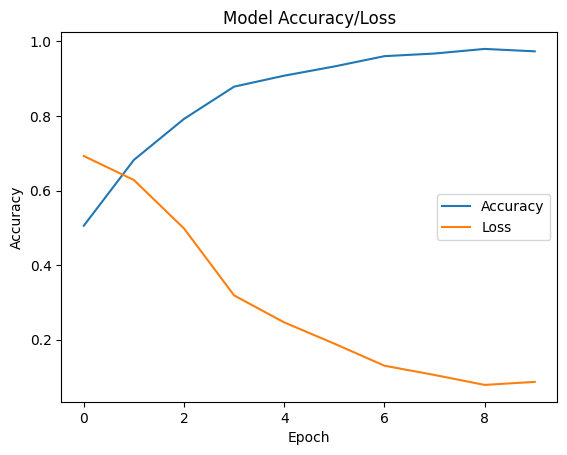

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Loss'], loc = 'center right')
plt.show()

In [19]:
validation_size = 75
batch_size = 32
X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

8/8 - 2s - loss: 0.5286 - accuracy: 0.8089 - 2s/epoch - 289ms/step
Score: 0.53
Validation Accuracy: 0.81


In [49]:
Y_pred = model.predict(X_validate)

# convert predicted probabilities to class labels
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_validate, axis=1)

# calculate classification report and confusion matrix
print("Classification Report:\n", classification_report(Y_true, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_true, Y_pred))

# calculate mean squared error, mean absolute error, and root mean squared error
mse = mean_squared_error(Y_true, Y_pred)
mae = mean_absolute_error(Y_true, Y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error: %.8f" % mse)
print("Mean Absolute Error: %.8f" % mae)
print("Root Mean Squared Error: %.8f" % rmse)

3/3 [==============================] - 1s 190ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.86        40
           1       0.82      0.89      0.85        35

    accuracy                           0.85        75
   macro avg       0.85      0.86      0.85        75
weighted avg       0.86      0.85      0.85        75

Confusion Matrix:
 [[33  7]
 [ 4 31]]
Mean Squared Error: 0.14666667
Mean Absolute Error: 0.14666667
Root Mean Squared Error: 0.38297084


In [2]:
import scipy.stats as stats
import numpy as np

BILSTM_acc = [0.9735,0.9800,0.9676,0.9749,0.9700]

mean_acc = np.mean(BILSTM_acc)
std_error = stats.sem(BILSTM_acc)

print('Mean accuracy: {:.4f} +/- {:.4f}'.format(mean_acc,std_error))

Mean accuracy: 0.9732 +/- 0.0021
